# LSTM auto-encoder with bidirectional encoder and seq2seq decoder with attention

In [1]:
import numpy as np 
import tensorflow as tf
import helpers #for formatting data into batches and generating random sequence data

tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
sess = tf.InteractiveSession() #initializes a tensorflow session

In [2]:
tf.__version__

'1.3.0'

In [3]:
PAD = 0 # padding
BOS = 1 # Begin of sequence
EOS = 2 # End of sequence

vocab_size = 10 # max length of input sequence
input_embedding_size = 20 #character length (vector)

encoder_hidden_units = 16 #num neurons
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
#input placehodlers
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
encoder_inputs_embedded

<tf.Tensor 'embedding_lookup:0' shape=(?, ?, 20) dtype=float32>

# Encoder
Bidirectional encoder

In [7]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple

In [8]:
encoder_cell =  LSTMCell(encoder_hidden_units)

In [9]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

In [10]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 16) dtype=float32>

In [11]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 16) dtype=float32>

In [12]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 16) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>)

In [13]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 16) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>)

In [14]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [15]:
encoder_outputs

<tf.Tensor 'concat:0' shape=(?, ?, 32) dtype=float32>

In [16]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'concat_1:0' shape=(?, 32) dtype=float32>, h=<tf.Tensor 'concat_2:0' shape=(?, 32) dtype=float32>)

# Decoder
Common part

In [17]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [18]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [19]:
decoder_lengths = encoder_inputs_length + 2
# +2 additional steps, +1 leading <EOS> token for decoder inputs

In [20]:
# +2 additional steps, +1 leading <EOS> token for decoder inputs as for decoder_lengths
max_length = encoder_max_time + 2

decoder_inputs = tf.ones([max_length, batch_size], dtype=tf.int32)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)
decoder_inputs_embedded

<tf.Tensor 'embedding_lookup_1:0' shape=(?, ?, 20) dtype=float32>

## Dynamic_rnn decoder
For comparison purpose (no attention mechanisms)

You can jump direclty to the seq2seq decoder part without running those cells

In [ ]:
((decoder_outputs),
 (decoder_state)) = (
    tf.nn.dynamic_rnn(cell=decoder_cell,
                      inputs=decoder_inputs_embedded, # Make sense for training but how to infer?
                      sequence_length=decoder_lengths,
                      initial_state=encoder_final_state,
                      dtype=tf.float32, time_major=True)
    )

In [ ]:
decoder_outputs

Output projection

In [ ]:
#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [ ]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [ ]:
decoder_logits

In [ ]:
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

## Seq2seq decoder

In [21]:
from tensorflow.python.layers import core as layers_core

In [22]:
# attention_states: [batch_size, max_time, num_units]
attention_states = tf.transpose(encoder_outputs, [1, 0, 2])

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    num_units=decoder_hidden_units, 
    memory=attention_states,
    #memory_sequence_length=None # default value
)

decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
    cell=decoder_cell, 
    attention_mechanism=attention_mechanism,
    attention_layer_size=decoder_hidden_units)

attention_zero = decoder_cell.zero_state(batch_size=batch_size, dtype=tf.float32)
encoder_final_state_attention = attention_zero.clone(cell_state=encoder_final_state)

In [23]:
projection_layer = layers_core.Dense(vocab_size, use_bias=True)

mode = 'infer'

# Helper
if mode == 'train':
    helper = tf.contrib.seq2seq.TrainingHelper(
        inputs=decoder_inputs_embedded, 
        sequence_length=decoder_lengths, 
        time_major=True)

elif mode == 'infer':
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
          embedding=embeddings,
          start_tokens=tf.tile([BOS], [batch_size]),
          end_token=EOS)

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    cell=decoder_cell, 
    helper=helper, 
    initial_state=encoder_final_state_attention, # to use without attention change to 'encoder_final_state'
    output_layer=projection_layer)

# Dynamic decoding
(decoder_outputs, final_state, final_sequence_lengths) = tf.contrib.seq2seq.dynamic_decode(
    decoder,
    output_time_major=True
)
decoder_logits = decoder_outputs.rnn_output
decoder_prediction = decoder_outputs.sample_id

In [24]:
decoder_outputs

BasicDecoderOutput(rnn_output=<tf.Tensor 'decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 10) dtype=float32>, sample_id=<tf.Tensor 'decoder/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, ?) dtype=int32>)

# Optimizer

In [25]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [26]:
sess.run(tf.global_variables_initializer())

# Load toy dataset

In [27]:
batch_size = 1

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=3, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[9, 5, 7, 5, 9]


In [28]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(
        [[BOS] + (sequence) + [EOS] for sequence in batch]
    )
    decoder_targets_, _ = helpers.batch(
        [[BOS] + (sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [29]:
loss_track = []

In [30]:
def train_model(max_batches=1001, batches_in_epoch=200):
    try:
        for batch in range(max_batches):
            fd = next_feed()
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)

            if batch == 0 or batch % batches_in_epoch == 0:
                predict_, l = sess.run([decoder_prediction, loss], fd)
                print('batch {}'.format(batch))
                print('  minibatch loss: {}'.format(l))
                for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    print('    input     > {}'.format(inp))
                    print('    predicted > {}'.format(pred))
                    if i >= 2:
                        break
                print

    except KeyboardInterrupt:
        print('training interrupted')

# Train the model
Possible to skip those cells and load a model checkpoint

In [31]:
train_model()

batch 0
  minibatch loss: 2.26167750359
  sample 1:
    input     > [1 3 9 4 3 2 0 0 0 0]
    predicted > [3 3 3 3 3 3 3 3 3 3 3 3]
  sample 2:
    input     > [1 3 4 3 8 3 2 0 0 0]
    predicted > [3 3 3 3 3 3 3 3 3 3 3 3]
  sample 3:
    input     > [1 7 6 3 6 7 6 2 0 0]
    predicted > [3 3 3 3 3 3 3 3 3 3 4 4]

batch 200
  minibatch loss: 0.685984611511
  sample 1:
    input     > [1 8 4 3 9 2 0 0 0 0]
    predicted > [1 8 4 3 9 2 0 0 0 0 0 0]
  sample 2:
    input     > [1 8 8 6 3 8 3 2 0 0]
    predicted > [1 8 8 8 8 8 3 2 0 0 0 0]
  sample 3:
    input     > [1 4 9 3 9 5 8 2 0 0]
    predicted > [1 9 9 9 9 9 8 2 0 0 0 0]

batch 400
  minibatch loss: 0.12656570971
  sample 1:
    input     > [1 6 6 9 3 5 3 6 2 0]
    predicted > [1 6 6 9 3 5 3 6 2 0 0 0]
  sample 2:
    input     > [1 8 9 7 6 2 0 0 0 0]
    predicted > [1 8 9 7 6 2 0 0 0 0 0 0]
  sample 3:
    input     > [1 4 6 4 6 3 9 2 0 0]
    predicted > [1 4 6 4 6 3 9 2 0 0 0 0]

batch 600
  minibatch loss: 0.0149441482499


Note: Remember that '1' is the BOS tag and '2' the EOS tag, not predicted outputs!

loss 0.0030 after 64064 examples (batch_size=64)


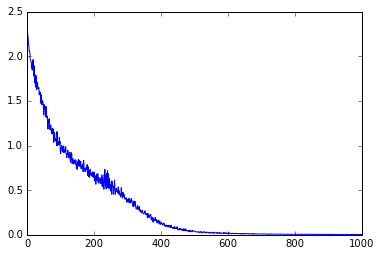

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

Save the model (create a checkpoint under the 'checkpoints' directory

In [33]:
saver = tf.train.Saver()
saver.save(sess, "checkpoints/seq2seq.ckpt")

'checkpoints/seq2seq.ckpt'

# Load a checkpoint

In [31]:
saver = tf.train.Saver()
saver.restore(sess, "checkpoints/seq2seq.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/seq2seq.ckpt


INFO:tensorflow:Restoring parameters from checkpoints/seq2seq.ckpt


In [32]:
fd = next_feed()
fd.pop(decoder_targets, None)
print(fd.keys())

[<tf.Tensor 'encoder_inputs:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'encoder_inputs_length:0' shape=(?,) dtype=int32>]


In [49]:
fd = next_feed()
fd.pop(decoder_targets, None)
pred, out, state = sess.run([decoder_prediction, encoder_outputs, encoder_final_state], fd)
print(out.shape)
print(state.c.shape)
f = fd[encoder_inputs].T
print(f[0])
print(pred.T[0])
print
print(state.c[0], out[0, 0])

(7, 1, 32)
(1, 32)
[1 8 6 9 4 7 2]
[1 8 6 9 4 7 7 2]

(array([ 0.40023291, -0.58917397, -2.30250072,  2.58669639, -0.91088206,
        1.16439533,  1.78416383,  0.96235991, -1.73630548, -0.46655616,
       -1.26378036,  2.70004392, -1.57479513, -1.96860933, -0.74386686,
       -1.75229454, -0.03932205, -0.69448853, -2.03278232,  2.42240119,
       -0.78706419,  1.69245625,  1.8588593 ,  1.04569674, -1.02659595,
       -1.69472444, -1.82233655,  2.21492791, -1.68707776, -2.41957664,
       -0.91299194, -1.56797767], dtype=float32), array([-0.04471743, -0.26471651,  0.17375033,  0.03144662,  0.03910483,
       -0.01637032,  0.35473436,  0.06948765,  0.08570214, -0.03199809,
        0.03975524, -0.12645589,  0.05322534, -0.02965113, -0.13658004,
        0.08771627, -0.01339012, -0.59790337, -0.82750249,  0.21970706,
       -0.45475811,  0.55341053,  0.83924961,  0.59622633, -0.23960082,
       -0.87738526, -0.8654319 ,  0.90147388, -0.6968345 , -0.90098828,
       -0.71534425, -0.76475066

# Visualize graph

Copy from https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter

In [31]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [32]:
show_graph(tf.get_default_graph().as_graph_def())